In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import matplotlib as mpl

from scipy.optimize import curve_fit
from scipy.stats import skewnorm
import scipy.integrate as integrate

In [2]:
Iax_dir = "/Users/tktakaro/Documents/Type-Iax-HST" #"D:/Research/Type-Iax-HST"
mist_dir = Iax_dir + "/MIST/WFC3_UVIS"

catalog = np.loadtxt(Iax_dir+"/new_files/sn2011ay/sn2011ay")

In [3]:
pos_predict = np.zeros((catalog.shape[0],2))
info_predict = np.zeros(np.shape(catalog))

j = 0 # Iteration variable for positions array
for i in range(catalog.shape[0]): # Cycles through each object in catalog
    # Checks to make sure point is "good"
    # Good defined by: 1. S/N > 3     2. Sharpness < .3    3. Roundness < 1     4. Crowding < .1 
    if ((catalog[i][5] >= 3.5)&(abs(catalog[i][6]) < .3)&(abs(catalog[i][7]) < 1)
        &(catalog[i][9] < .1)):
        pos_predict[j][0] = catalog[i][2] # Assigns X position
        pos_predict[j][1] = catalog[i][3] # Assigns Y position
        info_predict[j] = catalog[i]
        j = j + 1
                
# Trims all zeros from end of positions array, left from "bad" objects
pos_predict = pos_predict[~np.all(pos_predict == 0, axis=1)]
info_predict = info_predict[~np.all(info_predict == 0, axis=1)]

# Saves high S/N object X,Y positions
np.savetxt("Region_files/sn2011ay_Prediction.reg", pos_predict, '%5.2f')

0 to 1 star found within 200 pc (depending on the distance to the galaxy used). Need to perform false star fitting.

## False Star Fitting

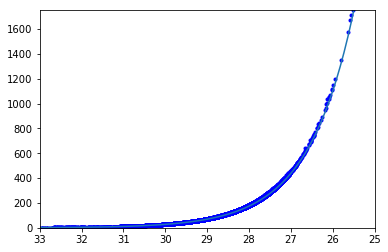

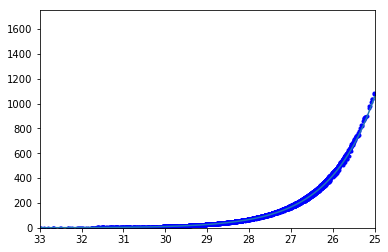

In [4]:
x_array = np.linspace(25,34,100)

plt.ylim(0,1750)
plt.xlim(33,25)
plt.plot(info_predict[:,15], info_predict[:,11], 'b.')
plt.plot(x_array, 2*710 * 10**((25.722 - x_array)/2.5))
plt.show()

plt.ylim(0,1750)
plt.xlim(33,25)
plt.plot(info_predict[:,28], info_predict[:,24], 'b.')
plt.plot(x_array, 2*780 * 10**((24.574 - x_array)/2.5))
plt.show()

In [5]:
# Generate false stars
x_pos = 2505 + 25*np.random.rand(50)
y_pos = 2825 + 25*np.random.rand(50)

f435w_mags = 18 + 12*np.random.rand(1000) # Range of 18 to 30 in mag
Iax_dir = "/Users/tktakaro/Documents/Type-Iax-HST"
file = open(Iax_dir + "/new_files/sn2011ay/fake_stars.list", "w+")
for j in range(x_pos.size):
    for i in range(f435w_mags.size):
        file.write('0 1 {x} {y} {f4} {f4} {f4} {f4}\n'.format(x=x_pos[j], y=y_pos[j], f4=f435w_mags[i]))
file.close()

In [6]:
# Loading in the false star test
catalog_false_f555w = np.loadtxt(Iax_dir + "/new_files/sn2011ay/sn2011ay_f555w.fake")
catalog_false_f814w = np.loadtxt(Iax_dir + "/new_files/sn2011ay/sn2011ay_f814w.fake")

In [7]:
recovered_mags = np.zeros([50000,13]) # 1. X position, 2. Y position, 3. Inserted Mag, 4. Recovered mag (f435w),
# 5. S/N (f435w), 6. Sharpness (f435w), 7. Roundness (f435w), 8. Crowding (f435w), 9.+ same, for other filters
for i in range(catalog_false_f555w.shape[0]):
    # X, Y, and Inserted Magnitude
    recovered_mags[i,0] = catalog_false_f555w[i,2]
    recovered_mags[i,1] = catalog_false_f555w[i,3]
    recovered_mags[i,2] = catalog_false_f555w[i,5]
    # Recovered mag in F555W
    if (catalog_false_f555w[i,14] == 0) and (catalog_false_f555w[i,15] == 0):
        recovered_mags[i,3] = 99.999
    else:
        recovered_mags[i,3] = catalog_false_f555w[i,27]
        recovered_mags[i,4:7] = catalog_false_f555w[i,17:20]
        recovered_mags[i,7] = catalog_false_f555w[i,21]
    # Recovered mag in F814W
    if (catalog_false_f814w[i,14] == 0) and (catalog_false_f814w[i,15] == 0):
        recovered_mags[i,8] = 99.999
    else:
        recovered_mags[i,8] = catalog_false_f814w[i,27]
        recovered_mags[i,9:12] = catalog_false_f814w[i,17:20]
        recovered_mags[i,12] = catalog_false_f814w[i,21]

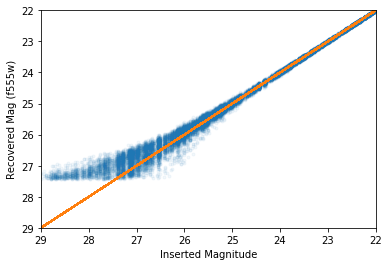

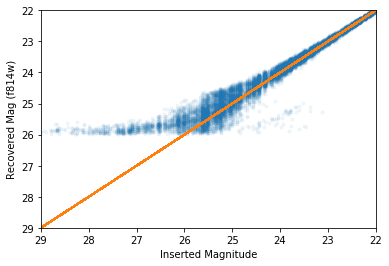

In [8]:
plt.plot(recovered_mags[:,2], recovered_mags[:,3], '.', alpha=.05)
plt.plot(recovered_mags[:,2], recovered_mags[:,2], '--')
plt.ylim(29,22)
plt.xlim(29,22)
plt.xlabel("Inserted Magnitude")
plt.ylabel("Recovered Mag (f555w)")
plt.show()

plt.plot(recovered_mags[:,2], recovered_mags[:,8], '.', alpha=.05)
plt.plot(recovered_mags[:,2], recovered_mags[:,2], '--')
plt.ylim(29,22)
plt.xlim(29,22)
plt.xlabel("Inserted Magnitude")
plt.ylabel("Recovered Mag (f814w)")
plt.show()

In [9]:
f555w_mags = []
f555w_recover = []
f814w_mags = []
f814w_recover = []
# Calculate recovery percentage as a function of inserted mag
for i in range(catalog_false_f555w.shape[0]):
    f555w_mags.append(recovered_mags[i,2])
    f814w_mags.append(recovered_mags[i,2])
    if abs(recovered_mags[i,2] - recovered_mags[i,3]) < .5:
        f555w_recover.append(recovered_mags[i,2])
    if abs(recovered_mags[i,2] - recovered_mags[i,8]) < .5:
        f814w_recover.append(recovered_mags[i,2])

In [10]:
# Setting up the histogram bins w/ .1 mag resolution
b = []
for i in range(121):
    b.append(17 + i/10.)

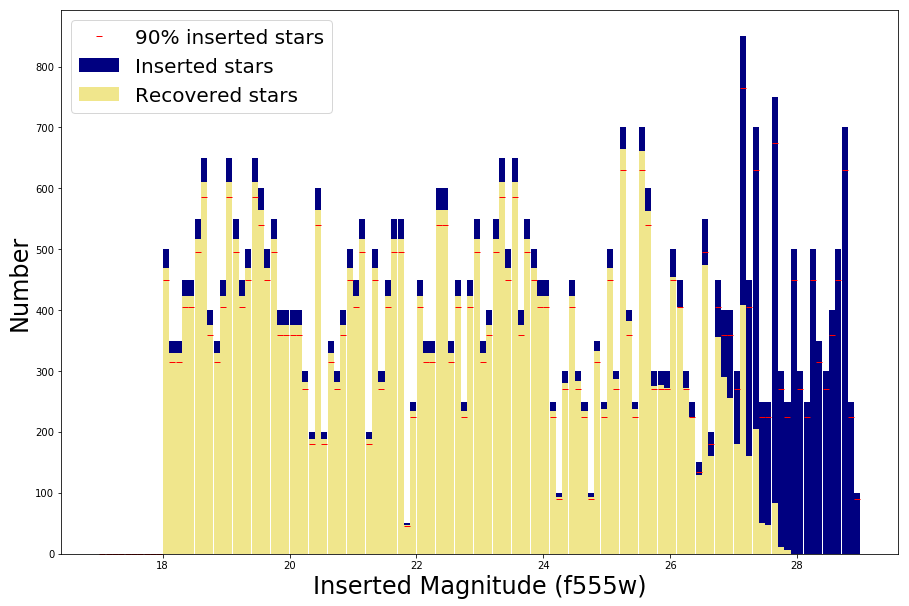

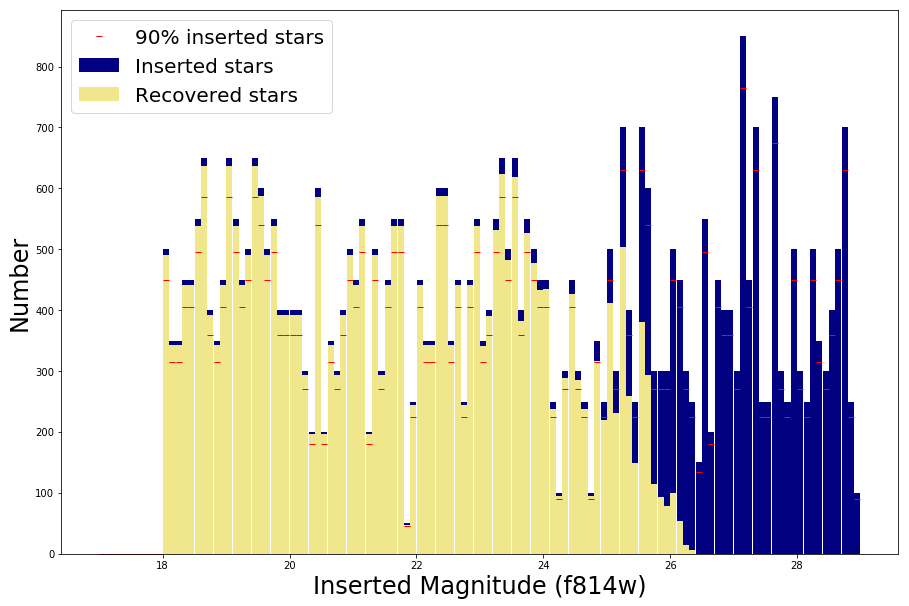

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


In [11]:
plt.subplots(figsize=(15, 10))
h5 = plt.hist(f555w_mags, bins=b, facecolor='navy', rwidth=.95, label='Inserted stars')
r5 = plt.hist(f555w_recover, bins=b, rwidth=.95, facecolor='khaki', label='Recovered stars')
plt.plot(h5[1][:-1]+.05, .9*h5[0], 'r_', markersize=6, label='90% inserted stars')
plt.xlabel("Inserted Magnitude (f555w)", fontsize=24)
plt.ylabel("Number", fontsize=24)
plt.legend(fontsize=20)
plt.show()

plt.subplots(figsize=(15, 10))
h8 = plt.hist(f814w_mags, bins=b, facecolor='navy', rwidth=.95, label='Inserted stars')
r8 = plt.hist(f814w_recover, bins=b, rwidth=.95, facecolor='khaki', label='Recovered stars')
plt.plot(h8[1][:-1]+.05, .9*h8[0], 'r_', markersize=6, label='90% inserted stars')
plt.xlabel("Inserted Magnitude (f814w)", fontsize=24)
plt.ylabel("Number", fontsize=24)
plt.legend(fontsize=20)
plt.show()

frac_f555w = r5[0]/h5[0]
frac_f814w = r8[0]/h8[0]

[ 26.35  24.85]


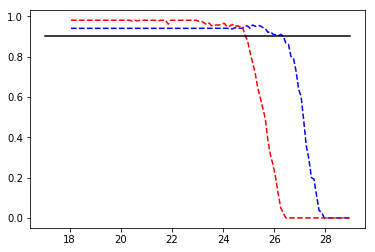

In [13]:
from scipy.interpolate import interp1d

plt.plot(h5[1][:-1]+.05, frac_f555w, 'b--')
plt.plot(h8[1][:-1]+.05, frac_f814w, 'r--')
plt.plot(h8[1][:-1]+.05, .9*np.ones(h8[1][:-1].shape), 'k-')

limit_mags = np.zeros(2)
limit_mags[0] = h5[1][10:-1][np.argmin(abs(frac_f555w[10:] - .9))] + .05
limit_mags[1] = h8[1][10:-1][np.argmin(abs(frac_f814w[10:] - .9))] + .05
print(limit_mags)

In [16]:
import os
import glob
import matplotlib as mpl

mist_dir = "/Users/tktakaro/Documents/Type-Iax-HST/MIST_v1.0_vvcrit0.4_HST_WFC3"
# All of this MIST isochrone code comes from Asher

kwargs = {"names": ["EEP", "log10_isochrone_age_yr", "initial_mass", "log_Teff", "log_g", "log_L",
                        "z_surf", "WFC3_UVIS_F200LP", "WFC3_UVIS_F218W", "WFC3_UVIS_F225W", "WFC3_UVIS_F275W",
                        "WFC3_UVIS_F280N", "WFC3_UVIS_F300X", "WFC3_UVIS_F336W", "WFC3_UVIS_F343N",
                        "WFC3_UVIS_F350LP", "WFC3_UVIS_F373N", "WFC3_UVIS_F390M", "WFC3_UVIS_F390W",
                        "WFC3_UVIS_F395N", "WFC3_UVIS_F410M", "WFC3_UVIS_F438W", "WFC3_UVIS_F467M",
                        "WFC3_UVIS_F469N", "WFC3_UVIS_F475W", "WFC3_UVIS_F475X", "WFC3_UVIS_F487N",
                        "WFC3_UVIS_F502N", "WFC3_UVIS_F547M", "WFC3_UVIS_F555W", "WFC3_UVIS_F600LP",
                        "WFC3_UVIS_F606W", "WFC3_UVIS_F621M", "WFC3_UVIS_F625W", "WFC3_UVIS_F631N",
                        "WFC3_UVIS_F645N", "WFC3_UVIS_F656N", "WFC3_UVIS_F657N", "WFC3_UVIS_F658N",
                        "WFC3_UVIS_F665N", "WFC3_UVIS_F673N", "WFC3_UVIS_F680N", "WFC3_UVIS_F689M",
                        "WFC3_UVIS_F763M", "WFC3_UVIS_F775W", "WFC3_UVIS_F814W", "WFC3_UVIS_F845M",
                        "WFC3_UVIS_F850LP", "WFC3_UVIS_F953N", "WFC3_IR_F098M", "WFC3_IR_F105W", "WFC3_IR_F110W",
                        "WFC3_IR_F125W", "WFC3_IR_F126N", "WFC3_IR_F127M", "WFC3_IR_F128N", "WFC3_IR_F130N",
                        "WFC3_IR_F132N", "WFC3_IR_F139M", "WFC3_IR_F140W", "WFC3_IR_F153M", "WFC3_IR_F160W",
                        "WFC3_IR_F164N", "WFC3_IR_F167N", "phase"],
            "delim_whitespace": True, "comment": "#"}
isochrones = {}
for filename in glob.glob(mist_dir + "/*.iso.cmd"):
    feh_string = filename.split("/")[-1].split("_")[3] # Pulls metalicity information
    if feh_string[0] == "p":
        feh = float(feh_string[1:]) # feh is [Fe/H]
    elif feh_string[0] == "m":
        feh = -float(feh_string[1:])
    else:
        raise ValueError
    df = pandas.read_csv(filename, **kwargs)
    df['ages'] = 10 ** df.log10_isochrone_age_yr / 1e9
    isochrones[feh] = df # Creates dictionary accessible by entering a particular metalicity

In [17]:
import scipy.integrate as integrate
def kroupa(m):
    norm = 0.32705769605379353 # integrated kroupa from .075 to 100
    if m < .08:
        alpha = .3
        return m**(-alpha)/norm
    elif m < .5:
        alpha = 1.3
        return .08 * m**(-alpha)/norm
    else:
        alpha = 2.3
        return .5 * .08 * m**(-alpha)/norm
def invertedKroupa(u):
    if u > kroupa(.08):
        return - np.log(u)/.3
    elif u > kroupa(.5):
        return - np.log(u)/(1.3 * .08)
    else:
        return - np.log(u)/(2.3 * .04)
    
print(integrate.quad(kroupa, 0.075, 100))

(1.0000000001709524, 1.3419911500261624e-08)


In [19]:
ages = np.array(list(set(df.log10_isochrone_age_yr)))
ages = ages[(ages > 6.49) & (ages < 8.51)]
ages.sort()
age_cmd = {}
dist_adjust = 5 * (np.log10(87.4e6) - 1)

ages_ruledout = []
for i, age in enumerate(ages):
    idx = df.log10_isochrone_age_yr == age
    # Two adjustments: 1. Distance: added to mag 2. Extinction: added to both.
    F555W_ext = 0.240 # extinction in F555W in NGC 1527 from NED
    F814W_ext = 0.129 # extinction in F814W in NGC 1527 from NED
    Gal_ext = 0 # THIS IS COMPLETELY UNCERTAIN
    mag5 = df[idx].WFC3_UVIS_F555W + dist_adjust + F555W_ext + 2.855*Gal_ext
    mag8 = df[idx].WFC3_UVIS_F814W + dist_adjust + F814W_ext + 1.536*Gal_ext
    mass = df[idx].initial_mass
    age_cmd[age] = (mag5, mag8, mass)

for age, (mag5, mag8, mass) in age_cmd.items():
    indices5 = []
    for i, mag in enumerate(mag5):
        if mag < limit_mags[0]:
            indices5.append(i)
    indices8 = []
    for i, mag in enumerate(mag8):
        if mag < limit_mags[1]:
            indices8.append(i)
            
    masses5 = []
    masses8 = []
    for i, mass in enumerate(mass):
        if np.isin(i, indices5):
            masses5.append(mass)
        if np.isin(i, indices8):
            masses8.append(mass)
            
    total_mass = 0
    n_inrange = 0
    while total_mass < 50:
        a = invertedKroupa(np.random.random())
        while a < .075 or a > 100: # Only uses stars with mass between .075 and 100 solar masses
            a = invertedKroupa(np.random.random())
        total_mass += a
        if not masses5 == []:
            if a > np.min(masses5) and a < np.max(masses5):
                n_inrange += 1
                continue
        if not masses8 == []:
            if a > np.min(masses8) and a < np.max(masses8):
                n_inrange += 1

    if n_inrange > 0:
        ages_ruledout.append(age)

In [20]:
ages_ruledout.sort()
print(np.round(ages_ruledout,2))
print("Max age ruled out is:", 10**(np.max(ages_ruledout))/1e6, "Myr")

[]


ValueError: zero-size array to reduction operation maximum which has no identity